O gráfico acima mostra como diferentes **larguras de banda (bandwidths)** afetam o ajuste de uma regressão local em um cenário de Regressão Discontínua (RDD). Interpretando:

* **±5** (mais estreito): o ajuste é feito com observações muito próximas ao ponto de corte. Estimativa mais "local", mas com maior incerteza (poucos dados).
* **±10** (moderado): bom equilíbrio entre viés e variância. Ajuste ainda reflete bem a vizinhança do corte.
* **±20** (mais largo): mais dados, menos variância, mas risco de incluir observações menos comparáveis, o que pode introduzir viés.

Esse tipo de visualização é útil para discutir **escolha do bandwidth** em sala de aula. Se quiser, posso preparar um notebook interativo com essa comparação ou incluir os coeficientes estimados para cada caso. Deseja isso?


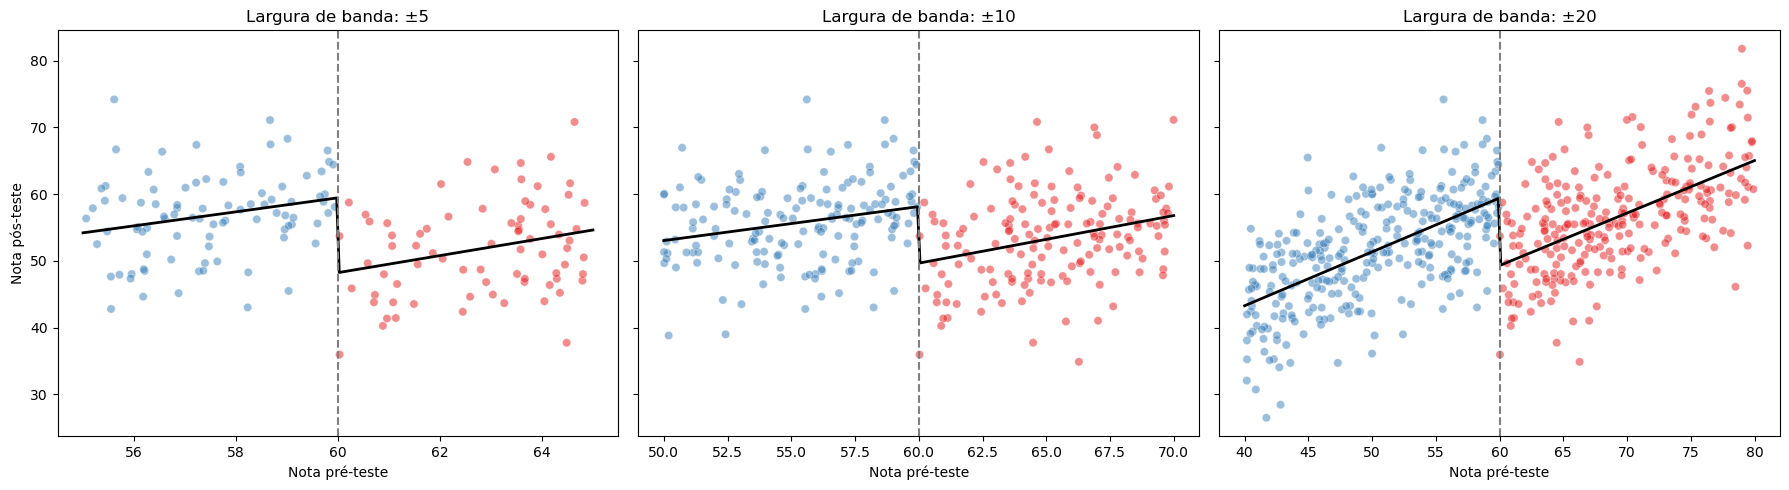

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Função para gerar dados simulados
def gerar_dados_rdd(n=1000, cutoff=60, effect=8):
    np.random.seed(42)
    running_var = np.random.beta(2, 2, n) * 100
    habilidade_inicial = 0.3 * running_var + np.random.normal(0, 5, n)
    motivacao = np.random.normal(50, 10, n)
    treatment = (running_var < cutoff).astype(int)
    outcome = (
        0.7 * running_var +
        0.2 * habilidade_inicial +
        0.1 * motivacao +
        effect * treatment +
        np.random.normal(0, 6, n)
    )
    return pd.DataFrame({
        'nota_pre': running_var,
        'tutoria': treatment,
        'nota_pos': outcome
    })

# Gerar dados
df = gerar_dados_rdd()

# Bandas a testar
bandwidths = [5, 10, 20]

# Plot
fig, axes = plt.subplots(1, len(bandwidths), figsize=(18, 5), sharey=True)
cutoff = 60

for ax, bw in zip(axes, bandwidths):
    df_bw = df[(df['nota_pre'] >= cutoff - bw) & (df['nota_pre'] <= cutoff + bw)]
    model = smf.ols("nota_pos ~ nota_pre * tutoria", data=df_bw).fit()
    x_vals = np.linspace(cutoff - bw, cutoff + bw, 200)
    pred_df = pd.DataFrame({
        "nota_pre": x_vals,
        "tutoria": (x_vals < cutoff).astype(int)
    })
    pred_df["nota_pos_pred"] = model.predict(pred_df)
    
    sns.scatterplot(data=df_bw, x="nota_pre", y="nota_pos", hue="tutoria", palette="Set1", ax=ax, alpha=0.5, legend=False)
    ax.plot(pred_df["nota_pre"], pred_df["nota_pos_pred"], color="black", lw=2)
    ax.axvline(cutoff, color="gray", linestyle="--")
    ax.set_title(f"Largura de banda: ±{bw}")
    ax.set_xlabel("Nota pré-teste")
    ax.set_ylabel("Nota pós-teste" if bw == bandwidths[0] else "")

plt.tight_layout()
plt.show()
